In [1]:
from utils import load_df
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses
import ipywidgets as ipw
import tensorflow as tf

In [6]:
train_df = load_df("data\\df_concat_train.pkl")
data = train_df["champs-elysees_Débit horaire"].to_numpy()

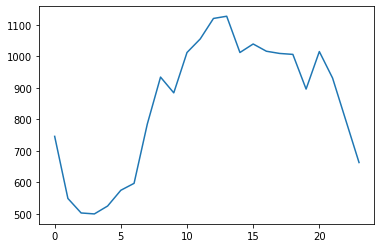

In [61]:
def get_X_y(data, nb_steps=24):
    """ returns the X and y vectors from dataframe 
        steps : nb of datapoints in each Xi
    """ 
    nb_train_ex = data.shape[0] - (nb_steps + 1) + 1 # 1 in () : the y 
    
    X = np.empty((nb_train_ex, nb_steps))
    y = np.empty((nb_train_ex,))
    for k_start in range(nb_train_ex):  
        X_k = data[k_start:k_start + nb_steps]
        y_k = data[k_start + nb_steps]

        example_id = k_start

        X[example_id, :] = X_k
        y[example_id] = y_k
    X_tensor = tf.convert_to_tensor(X.reshape((nb_train_ex, nb_steps, 1)))
    y_tensor = tf.convert_to_tensor(y)
    return X_tensor, y_tensor


X, y = get_X_y(data)
plt.plot(X[0])


In [62]:
def model_1(nb_steps=24, show_summary=False):
    input_shape = (nb_steps, 1)
    print("input shape : ", input_shape)
    
    model = models.Sequential()

    model.add(layers.Conv1D(256, kernel_size=(4,), padding='same',
                        input_shape=input_shape, activation="relu"))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Dropout(0.2))

#     model.add(layers.Conv1D(128, kernel_size=(3,), activation="relu"))
#     model.add(layers.MaxPooling1D(3))
#     model.add(layers.Dropout(0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation="relu"))
    model.add(layers.Dense(128, activation="relu"))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(32, activation="relu"))
    model.add(layers.Dense(1, activation="linear"))
    
    if show_summary:
        model.summary()
        
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    
    return model

# test
cnn_model_1 = model_1(show_summary=True) 

input shape :  (24, 1)
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 24, 256)           1280      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 12, 256)           0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 12, 256)           0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               393344    
_________________________________________________________________
dense_20 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_21 (Dense)             (N

In [63]:
cnn_model_1.fit(X, y, batch_size=32, epochs=100, verbose=1)

Train on 9235 samples
Epoch 1/100
9235/9235 [==============================] - 1s 131us/sample - loss: 25983.1159 - mae: 105.9743
Epoch 2/100
9235/9235 [==============================] - 1s 90us/sample - loss: 11909.5328 - mae: 78.1801
Epoch 3/100
9235/9235 [==============================] - 1s 91us/sample - loss: 12028.1156 - mae: 78.2945
Epoch 4/100
9235/9235 [==============================] - 1s 87us/sample - loss: 11083.2933 - mae: 75.1446
Epoch 5/100
9235/9235 [==============================] - 1s 89us/sample - loss: 11015.3324 - mae: 74.8103
Epoch 6/100
9235/9235 [==============================] - 1s 89us/sample - loss: 10665.1752 - mae: 73.3127
Epoch 7/100
9235/9235 [==============================] - 1s 88us/sample - loss: 10151.1605 - mae: 71.6577
Epoch 8/100
9235/9235 [==============================] - 1s 90us/sample - loss: 10326.5995 - mae: 71.9358
Epoch 9/100
9235/9235 [==============================] - 1s 89us/sample - loss: 9565.0109 - mae: 68.2775
Epoch 10/100
9235/9235 

KeyboardInterrupt: 

567.3679


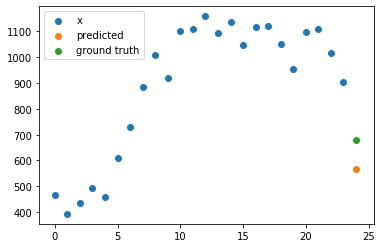

In [58]:
def show_one_pred(model, X, y, i):
    """ computes rmse & shows the predicted point """
    y_pred = model.predict(X[i].reshape(1, 24, 1))
    print(y_pred[0][0])
    abscissa = list(range(24))
    plt.scatter(abscissa, y[i:i+24], label="x")
    plt.scatter([i+24], [y_pred[0][0]], label="predicted")
    plt.scatter([i+24], y[i+24], label="ground truth")
    plt.legend()
    
show_one_pred(cnn_model_1, X, y, 0)

In [59]:
def predict_one_week(model, X):
    """ predicts y for 24*7 = 168 hours 
        first, we will only return the predicted y for <champs-elysees_Débit horaire>
        
        steps : 
            - get the 24 first values of each feature, put it in a np array
            - predict the 25th for features_to_predict
            - store <champs-elysees_Débit horaire> in a list
            - create one complete line with predicted and not predicted
            - add this line to the examples
            - take the 24 last values 
    """
    nb_predict = 24 * 7 # change to parameters
    
    # array qui contiendra les prédictions des y
    predicted_y = np.empty(nb_predict)
    # array qui contiendra les X
    X_24 = np.empty((24 + nb_predict))
    # on le remplit avec les premieres valeurs
    first_24_X = X[0].flatten()
    X_24[0:24] = first_24_X
    
    for i in range(nb_predict):
        
        # get the inputs
        next_24_X = X_24[i:24 + i].reshape(1, 24,1)
        # predict the 24+i th value
        f_y_pred = model.predict(next_24_X)
        # store <champs-elysees_Débit horaire> in a list
        predicted_y[i] = f_y_pred[0][0]
        # create one complete line with predicted and not predicted
        X_24[24 + i] = f_y_pred[0][0]
    
    return predicted_y

pred_y = predict_one_week(cnn_model_1, X)
ground_truth_y = X[24:24 + 24*7].flatten()

533.801717939831


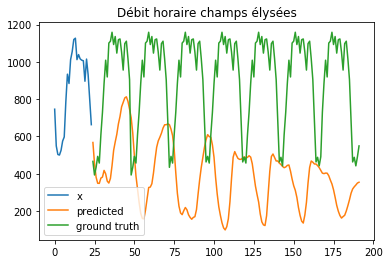

In [60]:
def display_comparison(X, true_y, pred_y, nb_steps):
    abscissa = range(24, 24 + nb_steps)
    plt.plot(range(24), X[0], label="x")
    plt.plot(abscissa, pred_y[:nb_steps], label="predicted")
    plt.plot(abscissa, ground_truth_y[:nb_steps], label="ground truth")
    plt.title("Débit horaire champs élysées")
    plt.legend()
display_comparison(X, ground_truth_y, pred_y, 168)
print(np.mean(abs(ground_truth_y[:168]-pred_y)))